#Timelagged Autoencoder (TAE)
Implementation of Timelagged Autoencoder (TAE) to perform a dimension reduction from the original three-dimensional
representation into a one-dimensional time series in such a way that the four different
states become disentangled

### Timelagged Autoencoder (TAE) paper

https://arxiv.org/abs/1710.11239

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
# view input file structure
dimux_npz = np.load('dimredux-challenge-01-data.npz')
dimux_npz.files

In [ ]:
with np.load('dimredux-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    validation_x = fh['validation_x']
    validation_y = fh['validation_y']

# TRAINING DATA: INPUT TIMESERIES DATA(x) 
print(data_x.shape, data_x.dtype)

# Validation DATA: INPUT (x) AND CLASS as TARGET
print(validation_x.shape, validation_x.dtype)
print(validation_y.shape, validation_y.dtype)

# Data processing: Whitening
https://courses.media.mit.edu/2010fall/mas622j/whiten.pdf

In [ ]:
def whiten(X, axis=0):
  X = X - X.mean(axis=axis)
  Xcov = np.dot(X.T,X) / len(X)
  eigh_val, eigh_vec = np.linalg.eigh(Xcov)
  D = np.diag(1. / np.sqrt(eigh_val))
  W_x = np.dot(D, eigh_vec.T)
  return np.dot(X, W_x.T)

In [ ]:
#using sklearn
from sklearn.decomposition import PCA
from scipy.linalg import fractional_matrix_power

def pca(x, remove_mean=True, whiten=True, axis=0):
    if remove_mean:
        x = x - x.mean(axis=axis)
    return PCA(whiten=whiten).fit_transform(x)


def whiten(x, axis=0):
    x = x - x.mean(axis=axis)
    n = np.take(x.shape, axis)
    cxx = fractional_matrix_power(np.matmul(x.T, x) / n, -1/2)
    return np.tensordot(x, cxx, axes=(1, 0))

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [ ]:
lag = 1
trn_X = data_x[0:-lag]
trn_Y = data_x[lag:]
val_X = validation_x[0:-lag]
val_Y = validation_x[lag:]

whitened_trn_X = whiten(trn_X) 
whitened_trn_Y = whiten(trn_Y)
whitened_val_X = whiten(val_X)
whitened_val_Y = whiten(val_Y)

whitened_trn_Xt = torch.tensor(whitened_trn_X.astype('float32'))
whitened_trn_Yt = torch.tensor(whitened_trn_Y.astype('float32'))
whitened_val_Xt = torch.tensor(whitened_val_X.astype('float32'))
whitened_val_Yt = torch.tensor(whitened_val_Y.astype('float32'))

batch_size = 64  # batch size
train_ds = TensorDataset(whitened_trn_Xt, whitened_trn_Yt)
train_dl = DataLoader(train_ds, batch_size=batch_size) #not shuffle coz of memory

# Define the network

In [ ]:
import torch.nn as nn

class Tae(nn.Module):
  
  def __init__(self):
      super(Tae, self).__init__()
      self.layer1 = nn.Linear(3, 128)
      self.layer2 = nn.Linear(128, 128)
      self.layer3 = nn.Linear(128, 32)
      self.layer4 = nn.Linear(32,1)
      self.layer5 = nn.Linear(1,32)
      self.layer6 = nn.Linear(32, 128)
      self.layer7 = nn.Linear(128, 128)
      self.layer8 = nn.Linear(128, 3)
      self.LeakyReLU = nn.LeakyReLU()
      #self.dropout = nn.Dropout(p=0.1)
  
  def encode(self, x):
    out = self.LeakyReLU(self.layer1(x))
    out = self.LeakyReLU(self.layer2(out))
    out = self.LeakyReLU(self.layer3(out))
    return self.LeakyReLU(self.layer4(out))
    
  def decode(self, x):
    out = self.LeakyReLU(self.layer5(x))
    out = self.LeakyReLU(self.layer6(out))
    out = self.LeakyReLU(self.layer7(out))
    return self.LeakyReLU(self.layer8(out))
  
  def forward(self,x):
    out = self.encode(x)
    out = self.decode(out)
    return out

net = Tae()
print(net)

Tae(
  (layer1): Linear(in_features=3, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=1, bias=True)
  (layer5): Linear(in_features=1, out_features=32, bias=True)
  (layer6): Linear(in_features=32, out_features=128, bias=True)
  (layer7): Linear(in_features=128, out_features=128, bias=True)
  (layer8): Linear(in_features=128, out_features=3, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.01)
)


# Training

In [ ]:
learning_rate = 0.001

#loss function
def criterion(X, y, data_size):
  return 1 / data_size * torch.norm(X-y, p='fro')

# Optimizer
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate)

In [ ]:
from torch import nn

training_size = len(train_dl.dataset)
validation_size = whitened_val_Xt.shape[0]
loss_epoch_trn_list, loss_epoch_val_list = [], [] # loss storage lists

for epoch in range(40):
  running_trn_loss, running_batch_trn_loss = 0.0 , 0.0
  print(f"\nEpoch {epoch+1}\n-------------------------------")
  
  #_______TRAINING___________#
  
  #net.train()

  for batch_num, (time_series_X, time_series_Y) in enumerate(train_dl):
    #input, label = input.to(device), label.to(device)
    # prediction
    pred = net(time_series_X) 
    loss = criterion(pred, time_series_X, batch_size) #evalute loss
    
    # backpropogation 
    loss.backward() 
    optimizer.step()
    optimizer.zero_grad() # zeroes the parameter gradients
    
    # statistics
    running_trn_loss += loss.item()
    running_batch_trn_loss += loss.item() 
  
  # cummulative training loss after each epoch
  epoch_mean_trn_loss = running_trn_loss / training_size
  loss_epoch_trn_list.append(epoch_mean_trn_loss)
  
  #______VALIDATION_______#

  net.eval()
  
  with torch.no_grad():
    predicted_Y = net(whitened_val_Xt)
    val_loss = criterion(predicted_Y, whitened_val_Yt, validation_size)
  epoch_mean_val_loss = val_loss / validation_size
  loss_epoch_val_list.append(epoch_mean_val_loss) # append to list

  print('Train Epoch:{} \t TrLoss:{:.6f} \t ValLoss:{:.6f}'.format(
            epoch, loss_epoch_trn_list[-1], loss_epoch_val_list[-1]))
  #saving model for minimum validation loss
  if loss_epoch_val_list[-1] <= min(loss_epoch_val_list):
    print("model saved\n")
    torch.save(net, './best_TAE.pth')


Epoch 1
-------------------------------
Train Epoch:0 	 TrLoss:0.002647 	 ValLoss:0.000051
model saved


Epoch 2
-------------------------------
Train Epoch:1 	 TrLoss:0.002002 	 ValLoss:0.000055

Epoch 3
-------------------------------
Train Epoch:2 	 TrLoss:0.001614 	 ValLoss:0.000057

Epoch 4
-------------------------------
Train Epoch:3 	 TrLoss:0.001389 	 ValLoss:0.000057

Epoch 5
-------------------------------
Train Epoch:4 	 TrLoss:0.001342 	 ValLoss:0.000057

Epoch 6
-------------------------------
Train Epoch:5 	 TrLoss:0.001220 	 ValLoss:0.000058

Epoch 7
-------------------------------
Train Epoch:6 	 TrLoss:0.001106 	 ValLoss:0.000061

Epoch 8
-------------------------------
Train Epoch:7 	 TrLoss:0.001064 	 ValLoss:0.000059

Epoch 9
-------------------------------


KeyboardInterrupt: ignored

In [ ]:
#load model and continue training
PATH = './best_TAE.pth'
our_saved_model = torch.load(PATH)

# Train further

In [ ]:
our_saved_model.train()
training_size = len(train_dl.dataset)
validation_size = whitened_val_Xt.shape[0]
#loss_epoch_trn_list, loss_epoch_val_list = [], [] # loss storage lists

for epoch in range(100):
  running_trn_loss, running_batch_trn_loss = 0.0 , 0.0
  print(f"\nEpoch {epoch+1}\n-------------------------------")
  
  #_______TRAINING___________#
  


  for batch_num, (time_series_X, time_series_Y) in enumerate(train_dl):
    #input, label = input.to(device), label.to(device)
    # prediction
    pred = net(time_series_X) 
    loss = criterion(pred, time_series_X, batch_size) #evalute loss
    
    # backpropogation 
    loss.backward() 
    optimizer.step()
    optimizer.zero_grad() # zeroes the parameter gradients
    
    # statistics
    running_trn_loss += loss.item()
    running_batch_trn_loss += loss.item() 
  
  # cummulative training loss after each epoch
  epoch_mean_trn_loss = running_trn_loss / training_size
  loss_epoch_trn_list.append(epoch_mean_trn_loss)
  
  #______VALIDATION_______#

  net.eval()
  
  with torch.no_grad():
    predicted_Y = net(whitened_val_Xt)
    val_loss = criterion(predicted_Y, whitened_val_Yt, validation_size)
  epoch_mean_val_loss = val_loss / validation_size
  loss_epoch_val_list.append(epoch_mean_val_loss) # append to list

  print('Train Epoch:{} \t TrLoss:{:.6f} \t ValLoss:{:.6f}'.format(
            epoch, loss_epoch_trn_list[-1], loss_epoch_val_list[-1]))
  #saving model for minimum validation loss
  if loss_epoch_val_list[-1] <= min(loss_epoch_val_list):
    print("model saved\n")
    torch.save(net, './best_TAE_2.pth')



Epoch 1
-------------------------------
Train Epoch:0 	 TrLoss:0.001224 	 ValLoss:0.000059

Epoch 2
-------------------------------
Train Epoch:1 	 TrLoss:0.001266 	 ValLoss:0.000057

Epoch 3
-------------------------------
Train Epoch:2 	 TrLoss:0.001246 	 ValLoss:0.000057

Epoch 4
-------------------------------
Train Epoch:3 	 TrLoss:0.001186 	 ValLoss:0.000058

Epoch 5
-------------------------------
Train Epoch:4 	 TrLoss:0.001165 	 ValLoss:0.000057

Epoch 6
-------------------------------
Train Epoch:5 	 TrLoss:0.001160 	 ValLoss:0.000057

Epoch 7
-------------------------------
Train Epoch:6 	 TrLoss:0.001155 	 ValLoss:0.000058

Epoch 8
-------------------------------
Train Epoch:7 	 TrLoss:0.001139 	 ValLoss:0.000061

Epoch 9
-------------------------------
Train Epoch:8 	 TrLoss:0.001203 	 ValLoss:0.000059

Epoch 10
-------------------------------
Train Epoch:9 	 TrLoss:0.001225 	 ValLoss:0.000061

Epoch 11
-------------------------------
Train Epoch:10 	 TrLoss:0.001202 	 Va

# Plotting underline features

In [ ]:
in_x = data_x
in_x -= in_x.mean(axis=0)
in_x = whiten(in_x)
tensor_in_x = torch.from_numpy(in_x.astype('float32'))
underline_features = our_saved_model.encode(tensor_in_x)

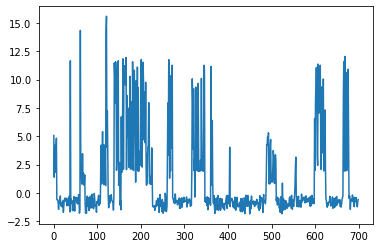

In [ ]:
plt.plot(underline_features[:700].detach().numpy())
plt.show()

# clustering purpose

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
underline_features_val = our_saved_model.encode(whitened_val_Xt)

In [ ]:
kmeans_underline = KMeans(n_clusters=4, random_state=0, max_iter=300).fit(underline_features_val.detach().numpy())

# Confusion matrix

In [ ]:
from  sklearn.metrics import confusion_matrix

In [ ]:
#labels r diiferent
confusion_matrix(validation_y[:-1], kmeans_underline.labels_)

array([[  0, 243,   0,  35],
       [  0, 256,   0,  25],
       [ 46,   8,  59, 118],
       [  0,  98,   0, 111]])

# Network Parameters : if necessary

In [ ]:
for name, param in our_saved_model.named_parameters():
    print(name, ':', param.requires_grad)

layer1.weight : True
layer1.bias : True
layer2.weight : True
layer2.bias : True
layer3.weight : True
layer3.bias : True
layer4.weight : True
layer4.bias : True
layer5.weight : True
layer5.bias : True
layer6.weight : True
layer6.bias : True
layer7.weight : True
layer7.bias : True
layer8.weight : True
layer8.bias : True
